In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import nltk
import gensim.downloader as api
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

In [ ]:
glove_model = api.load("glove-wiki-gigaword-100")

In [ ]:
data_file = 'Sentiment.csv'
data = pd.read_csv(data_file)
data = data[['text', 'sentiment']]

In [ ]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+', 'url', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', 'email', text)

    # Remove emojis
    text = remove_emojis(text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = nltk.word_tokenize(text.lower())

    # Lemmatize
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]

    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # Stemming
    tokens = [porter_stemmer.stem(token) for token in tokens]

    return tokens

In [ ]:
def get_sentence_embedding(tokens, embedding_model, embedding_size, length_limit):
    token_embeddings = [embedding_model[token] for token in tokens if token in embedding_model]
    padding = np.zeros(embedding_size)

    if len(token_embeddings) > 0:

        if len(token_embeddings) > length_limit:
            token_embeddings = token_embeddings[:length_limit]
        elif len(token_embeddings) < length_limit:
            token_embeddings = token_embeddings + [padding] * (length_limit - len(token_embeddings))

        sentence_embedding = np.concatenate(token_embeddings, axis=0)

    else:
        sentence_embedding = np.zeros(embedding_size * length_limit)

    return sentence_embedding

In [ ]:
def create_glove_embeddings(data, glove_model):
    length_limit = 25
    embedding_size = glove_model.vector_size
    embeddings = np.zeros((len(data), embedding_size * length_limit))

    for i, text in enumerate(data['text']):
        embeddings[i] = get_sentence_embedding(preprocess_text(text), glove_model, embedding_size, length_limit)

    return embeddings

In [ ]:
embedding_size = glove_model.vector_size

In [ ]:
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
X_train = create_glove_embeddings(train_data, glove_model)
X_test = create_glove_embeddings(test_data, glove_model)
X_val = create_glove_embeddings(val_data, glove_model)

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['sentiment'])
y_test = label_encoder.transform(test_data['sentiment'])
y_val = label_encoder.transform(val_data['sentiment'])

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.int64).to(device)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(Transformer, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Linear(input_size, hidden_size)
        self.pos_encoder = PositionalEncoding(hidden_size, dropout_rate)
        encoder_layers = TransformerEncoderLayer(hidden_size, nhead=8, dim_feedforward=hidden_size*4, dropout=dropout_rate)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x) * np.sqrt(float(self.hidden_size))
        x = self.pos_encoder(x.unsqueeze(1))
        x = self.transformer_encoder(x)
        x = x[:, 0, :]
        x = self.fc(x)
        return x

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(1), :]
        return self.dropout(x)

In [ ]:
def precision_recall_fscore(y_true, y_pred):
    num_classes = len(set(y_true))
    tp, fp, fn = [0] * num_classes, [0] * num_classes, [0] * num_classes

    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            tp[y_true[i]] += 1
        else:
            fp[y_pred[i]] += 1
            fn[y_true[i]] += 1

    precision = [tp[i] / (tp[i] + fp[i]) if (tp[i] + fp[i]) > 0 else 0 for i in range(num_classes)]
    recall = [tp[i] / (tp[i] + fn[i]) if (tp[i] + fn[i]) > 0 else 0 for i in range(num_classes)]

    return precision, recall

In [ ]:
def f1_score_weighted(y_true, y_pred):
    # Convert tensors to lists
    y_true = y_true.tolist()
    y_pred = y_pred.tolist()

    precision, recall = precision_recall_fscore(y_true, y_pred)

    f1_scores = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

    class_counts = [y_true.count(i) for i in set(y_true)]
    total_samples = len(y_true)

    weighted_f1 = sum(f1 * count / total_samples for f1, count in zip(f1_scores, class_counts))

    return weighted_f1

In [ ]:
hidden_size = 512
num_epochs = 100
learning_rate = 0.00001
patience = 10
stop_counter = 0
best_val_loss = np.inf
num_layers = 3
dropout_rate = 0.3

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))

model = Transformer(input_size, hidden_size, num_layers, num_classes, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct, train_total = 0, 0
    for inputs, labels in train_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_dataloader))
    train_accuracy = train_correct / train_total * 100
    train_accuracies.append(train_accuracy)
    train_f1 = f1_score_weighted(y_train_tensor, model(X_train_tensor).argmax(dim=1))
    train_f1_scores.append(train_f1)

    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_dataloader))
    val_accuracy = val_correct / val_total * 100
    val_accuracies.append(val_accuracy)
    val_f1 = f1_score_weighted(y_val_tensor, model(X_val_tensor).argmax(dim=1))
    val_f1_scores.append(val_f1)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, Train F1: {train_f1:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.2f}%, Val F1: {val_f1:.4f}')

    # if val_losses[-1] < best_val_loss:
    #     best_val_loss = val_losses[-1]
    #     stop_counter = 0
    #     torch.save(model.state_dict(), 'best_model.pt')
    # else:
    #     stop_counter += 1
    #     if stop_counter >= patience:
    #         print("Early stopping triggered.")
    #         break

# model.load_state_dict(torch.load('best_model.pt'))

model.eval()
test_loss = 0.0
test_correct, test_total = 0, 0
with torch.no_grad():
    for inputs, labels in val_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total * 100
test_f1 = f1_score_weighted(y_test_tensor, model(X_test_tensor).argmax(dim=1))

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1: {test_f1:.4f}')

Epoch [1/100], Train Loss: 0.9507, Train Accuracy: 59.53%, Train F1: 0.4970, Val Loss: 0.8785, Val Accuracy: 61.75%, Val F1: 0.5056
Epoch [2/100], Train Loss: 0.9008, Train Accuracy: 60.86%, Train F1: 0.4954, Val Loss: 0.8586, Val Accuracy: 62.33%, Val F1: 0.5226
Epoch [3/100], Train Loss: 0.8805, Train Accuracy: 61.76%, Train F1: 0.5369, Val Loss: 0.8383, Val Accuracy: 62.61%, Val F1: 0.5648
Epoch [4/100], Train Loss: 0.8603, Train Accuracy: 62.43%, Train F1: 0.5815, Val Loss: 0.8413, Val Accuracy: 61.80%, Val F1: 0.5947
Epoch [5/100], Train Loss: 0.8485, Train Accuracy: 62.99%, Train F1: 0.5845, Val Loss: 0.8248, Val Accuracy: 63.38%, Val F1: 0.5931
Epoch [6/100], Train Loss: 0.8284, Train Accuracy: 64.08%, Train F1: 0.6001, Val Loss: 0.8235, Val Accuracy: 63.33%, Val F1: 0.6052
Epoch [7/100], Train Loss: 0.8264, Train Accuracy: 64.24%, Train F1: 0.5999, Val Loss: 0.8189, Val Accuracy: 63.58%, Val F1: 0.6078
Epoch [8/100], Train Loss: 0.8155, Train Accuracy: 64.46%, Train F1: 0.6106,

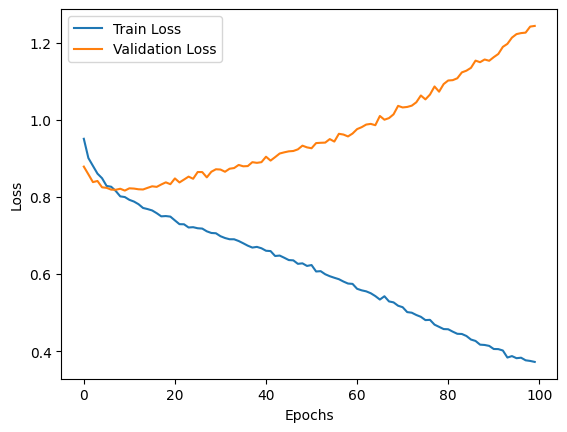

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

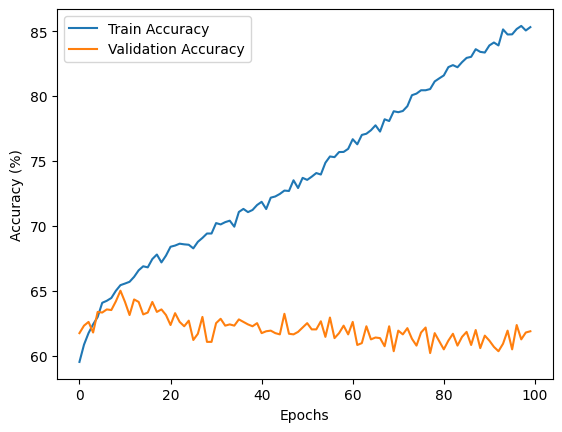

In [ ]:
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

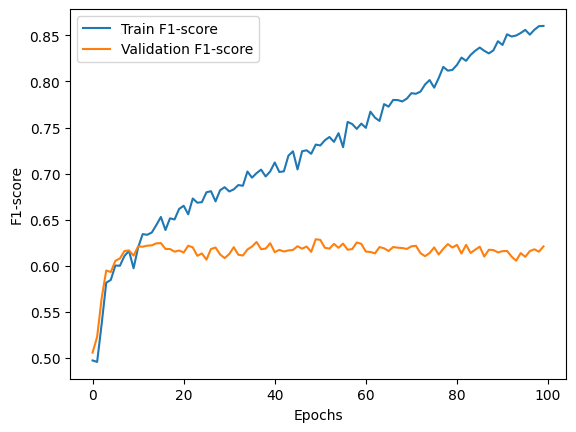

In [ ]:
plt.figure()
plt.plot(train_f1_scores, label='Train F1-score')
plt.plot(val_f1_scores, label='Validation F1-score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()